## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
epoch_num=50
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler
import torch.optim as optim
from Annotatability import models, metrics


In [2]:
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from collections import Counter


In [3]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        """
        Initializes a feedforward neural network with three fully-connected layers.

        Args:
            input_size (int): Size of the input layer.
            output_size (int): Size of the output layer.
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, int(input_size / 2))
        self.fc2 = nn.Linear(int(input_size / 2), int(input_size / 4))
        self.fc3 = nn.Linear(int(input_size / 4), output_size)

    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Output data of shape (batch_size, output_size).
        """
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x)
        return output

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.
    
    Args:
        labels (numpy.ndarray): Array of labels.
        
    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    #print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder


    
def fit_nn(tensor_x, tensor_y, label_key, iterNum=20, lr=0.001, momentum=0.9,
                    device='cpu', weighted_sampler=True, batch_size=64):
    net = Net(tensor_x.shape[1], output_size=tensor_y.shape[1])
    #one_hot_label, inverted_label = one_hot_encode(adata.obs[label_key])
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    tensor_x = torch.Tensor(tensor_x)  # Transform to torch tensor
    tensor_x = tensor_x.to(device)
    tensor_y = tensor_y.to(device)
    my_dataset = TensorDataset(tensor_x, tensor_y)  # Create your dataset
    trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size,
                                                  shuffle=True, num_workers=0)
    for epoch in range(iterNum):  # Loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if device.type != 'cpu':
                #print('Running with cuda')
                inputs, labels = inputs.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 1:  # Print every 10 mini-batches
                #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0
    return net

def is_scipy_cs_sparse(matrix):
    """
    Check if a matrix is a Compressed Sparse Row (CSR) matrix using scipy.

    Parameters:
    ----------
    matrix : scipy.sparse.spmatrix
        The input matrix to be checked.

    Returns:
    -------
    bool
        True if the input matrix is a CSR matrix, False otherwise.

    """
    return sp.issparse(matrix) and matrix.getformat() == 'csr'

def multi_ada_sampling_nn(data, adata, label_key, classifier="nn",device='cpu', percent=1, L=10, prob_output=False, balance=True, iter=3):
    def update_xy(vote_class, label, percent, balance):
        sample_size = int(np.round(np.median(list(Counter(label).values()))))
        idx = []
        if balance:
            idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        else:
            if len(vote_class) > sample_size:
                idx = resample(np.arange(len(vote_class)), n_samples=int(sample_size * percent), replace=True, stratify=vote_class)
            else:
                idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        
        return x_data[idx,:].T, label[idx]

    models = []
    #print(adata.obs[label_key])
    one_hot_label, inverted_label, intger_label  = one_hot_encode_integer(adata.obs[label_key])
    label=intger_label
    intger_label = intger_label.flatten()
    #print(label.shape)
    if is_scipy_cs_sparse(adata.X):
        x_data = adata.X.toarray()
    else:
        x_data = np.array(adata.X)
    tensor_x = torch.Tensor(x_data)  # Transform to torch tensor
    tensor_y = torch.Tensor(one_hot_label)
    tensor_x = tensor_x.to(device)
    tensor_y = tensor_y.to(device)


    for _ in range(L):
        X = tensor_x
        Y = tensor_y
        model_list = []
        prob_list = []
        
        for _ in range(iter):
            #print(X.shape)
            #print(Y.shape)
            net = fit_nn(X, Y, label_key=label_key, device=device)
            prob = net(X)
            prob = torch.exp(prob)
            prob = prob.detach().cpu().numpy()
            X, Y = [], []
            xy_update = []
            #print(Counter(label.flatten()))
            #print(prob.shape)
            label=label.flatten()
            for j in range(prob.shape[1]):
                vote_class = prob[label == j]
                #vote_class = prob[(label == j),:]
                #vote_class= vote_class.detach().cpu()
                xy_update.append(update_xy(vote_class, label, percent, balance))
            cur_X = np.column_stack([xy[0] for xy in xy_update])
            cur_X = np.array(cur_X.T)

            cur_Y = np.concatenate([xy[1] for xy in xy_update])
            #print(cur_Y)
            X, Y = cur_X, cur_Y
            #print(X)
            X = torch.Tensor(X).to(device)
            new_Y , _ , _  = one_hot_encode_integer(cur_Y)
            Y =  torch.Tensor(new_Y).to(device)
        models.append(net)
    
    predict_mat = np.zeros((tensor_x.shape[0], len(np.unique(label))))
    #print('predict_mat')
    #print(predict_mat.shape)
    final = []
    for model in models:
        if classifier == "svm":
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        else:
            tmp = model(tensor_x)
            tmp = torch.exp(tmp)
        #print('tmp')
        #print(tmp.shape)
        predict_mat += tmp.detach().cpu().numpy()
    
    if prob_output:
        final = np.max(predict_mat, axis=1)
        final = dict(zip(list(np.unique(label))[np.argmax(predict_mat, axis=1)], final))
    else:
        final = 0#list(np.unique(label))[np.argmax(predict_mat, axis=1)]
    
    return predict_mat[np.arange(adata.n_obs),intger_label]/L

def create_weighted_sampler(adata, label_key):
    """
    Create a weighted sampler to handle class imbalance for a given label in an AnnData object.

    This function computes class weights based on the distribution of labels and creates
    a weighted sampler for training data to address class imbalance issues.

    Parameters:
    ----------
    adata : AnnData
        Anndata object containing the data.

    label_key : str
        The key in adata.obs where the class labels are stored.

    Returns:
    -------
    WeightedRandomSampler
        A weighted sampler that can be used with DataLoader to handle class imbalance.

    Notes:
    ------
    - Ensure that the AnnData object ('adata') contains a column with class labels specified
      by the 'label_key' parameter.
    - The returned WeightedRandomSampler can be used with PyTorch DataLoader to sample
      batches with class-awareness.
    """
    y_train = adata.obs[label_key]
    y_train_indices = y_train.unique()
    class_sample_count = np.array([sum(y_train == t) for t in y_train_indices])
    weight = 1.0 / class_sample_count
    samples_weight = np.zeros(adata.n_obs)
    for i in range(adata.n_obs):
        for j, t in enumerate(y_train_indices):
            if adata.obs[label_key][i] == t:
                samples_weight[i] = weight[j]
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    return sampler

def one_hot_encode_integer(labels):
    """
    One-hot encodes an array of labels.

    Args:
        labels (numpy.ndarray): Array of labels.

    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)

    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    # binary encode
    onehot_encoder = OneHotEncoder()
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    #inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    if is_scipy_cs_sparse(onehot_encoded):
        onehot_encoded = onehot_encoded.toarray()
    return onehot_encoded, label_encoder , integer_encoded




In [4]:
import random
def random_sample_and_number(strings):
    if len(strings) < 4:
        raise ValueError("The list must contain at least 4 strings.")
    
    sampled_strings = random.sample(strings, 4)
    numbered_strings = {sampled_strings[i]: i for i in range(4)}
    
    return numbered_strings

def create_intermediate_state(adata,key,labels):
    bdata = adata.copy()
    # change_weight= np.random.normal(0,0.5,adata.n_obs)
    # change_weight  =np.clip(change_weight, a_max=0.5, a_min=0)
    half_size = adata.n_obs // 2
    zeros = np.zeros(half_size)
    uniform_values = np.random.uniform(0.0, 1, adata.n_obs - half_size)
    samples = np.concatenate((zeros, uniform_values))
    np.random.shuffle(samples)
    change_weight = samples
    for i in range(adata.n_obs):
        if adata.obs[key][i] in labels:
            for label in labels:
                if label != adata.obs[key][i]:
                    adata_tmp= adata[adata.obs[key].isin([label])]
                    bdata[i].X = (1-change_weight[i])*adata[i].X + change_weight[i]* adata_tmp[np.random.randint(adata_tmp.n_obs)].X
        else:
            change_weight[i]=0
    bdata.obs['change_weight']+=change_weight
    return bdata

def create_intermediate_state_percent(adata,key,labels,percent):
    bdata = adata.copy()
    n=adata.n_obs
    # change_weight= np.random.normal(0,0.5,adata.n_obs)
    # change_weight  =np.clip(change_weight, a_max=0.5, a_min=0)
    values_to_change=int(n *percent)
    zeros = np.zeros(n-values_to_change)
    uniform_values = np.random.uniform(0.0, 1, values_to_change)
    samples = np.concatenate((zeros, uniform_values))
    np.random.shuffle(samples)
    change_weight = samples
    for i in range(adata.n_obs):
        if adata.obs[key][i] in labels:
            for label in labels:
                if label != adata.obs[key][i]:
                    adata_tmp= adata[adata.obs[key].isin([label])]
                    bdata[i].X = (1-change_weight[i])*adata[i].X + change_weight[i]* adata_tmp[np.random.randint(adata_tmp.n_obs)].X
        else:
            change_weight[i]=0
    bdata.obs['change_weight']+=change_weight
    return bdata



import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


def multi_ada_sampling(data, label, classifier="svm", percent=1, L=10, prob_output=False, balance=True, iter=3):
    def update_xy(vote_class, label, percent, balance):
        sample_size = int(np.round(np.median(list(Counter(label).values()))))
        idx = []
        if balance:
            idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        else:
            if len(vote_class) > sample_size:
                idx = resample(np.arange(len(vote_class)), n_samples=int(sample_size * percent), replace=True, stratify=vote_class)
            else:
                idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        
        return data[:, idx], label[idx]

    models = []
    for _ in range(L):
        X = data
        Y = label
        model_list = []
        prob_list = []
        
        for _ in range(iter):
            if classifier == "rf":
                model = RandomForestClassifier(n_estimators=100)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier == "svm":
                model = SVC(probability=True)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier =="knn":
                model = KNeighborsClassifier()
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
                #print(prob)
            else:
                raise ValueError(f"Unknown classifier: {classifier}")
            
            X, Y = [], []
            xy_update = []
            for j in range(prob.shape[1]):
                vote_class = prob[label == j]
                xy_update.append(update_xy(vote_class, label, percent, balance))
            
            cur_X = np.column_stack([xy[0] for xy in xy_update])
            cur_Y = np.concatenate([xy[1] for xy in xy_update])
            X, Y = cur_X, cur_Y
        models.append(model)
    
    predict_mat = np.zeros((data.shape[1], len(np.unique(label))))
    final = []
    for model in models:
        if classifier == "svm":
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        else:
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        predict_mat += tmp
    
    if prob_output:
        final = np.max(predict_mat, axis=1)
        final = dict(zip(list(np.unique(label))[np.argmax(predict_mat, axis=1)], final))
    else:
        final = 0#list(np.unique(label))[np.argmax(predict_mat, axis=1)]
    
    return {"final": final, "models": models, "prob": predict_mat}

def get_conf_from_scReClassify(adata, res , formerlabels, L=10):
    prob_mat= res['prob']
    return prob_mat[np.arange(len(prob_mat)), formerlabels]/L


In [5]:
adata = sc.read('GSE128565_adata_processed.h5ad.h5')
adata

AnnData object with n_obs × n_vars = 32888 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond'
    var: 'n_cells', 'highly_variable_genes'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'groups_named_fine_colors', 'proliferation_colors', 'proliferation_man_colors', 'rank_genes_groups', 'treatment_colors', 'treatment_colors_rgb'
    obsm: 'X_umap'

In [6]:
adata.obs['groups_named_broad_cond']

index
AAACCTGAGACGCAAC-1_G1      alpha_Ctrl
AAACCTGAGGAGTCTG-1_G1       beta_Ctrl
AAACCTGCAAGTCTAC-1_G1       beta_Ctrl
AAACCTGCACACCGCA-1_G1       poly_Ctrl
AAACCTGCACGGTTTA-1_G1       beta_Ctrl
                             ...     
TTTGTCAAGGACCACA-1_G8    beta_InsGLP1
TTTGTCACAATAAGCA-1_G8    delta_InsGLP
TTTGTCACAGACGCCT-1_G8     PP_InsGLP1E
TTTGTCAGTGACTCAT-1_G8     PP_InsGLP1E
TTTGTCATCGTGACAT-1_G8    delta_InsGLP
Name: groups_named_broad_cond, Length: 32888, dtype: category
Categories (35, object): ['beta_Ctrl', 'beta_Est', 'beta_GLP1', 'beta_GLP1E', ..., 'poly_GLP1E', 'poly_Ins', 'poly_InsGLP1', 'poly_STZ']

In [7]:
adata_alpha = adata[adata.obs['groups_named_broad_cond'].isin(['alpha_Ctrl',
                                                             'alpha_STZ','alpha_GLP1','alpha_Ins','alpha_InsGLP','alpha_Est','alpha_GLP1E'])]

adata_beta = adata[adata.obs['groups_named_broad_cond'].isin(['beta_STZ','beta_GLP1','beta_Ins','beta_InsGLP1','beta_Est','beta_GLP1E','beta_Ctrl'])]

adata_delta = adata[adata.obs['groups_named_broad_cond'].isin([ 'delta_STZ','delta_GLP1','delta_Ins','delta_InsGLP','delta_Est','delta_GLP1E','delta_Ctrl'])]

adata_PP= adata[adata.obs['groups_named_broad_cond'].isin([ 'PP_STZ','PP_GLP1','PP_Ins','PP_InsGLP','PP_Est','PP_GLP1E','PP_Ctrl'])]


adata_alpha.obs['celltype']='alpha'
adata_beta.obs['celltype']='beta'
adata_delta.obs['celltype']='delta'
adata_PP.obs['celltype']='PP'
adata_celltype = adata_alpha.concatenate(adata_beta)
adata_celltype = adata_celltype.concatenate(adata_delta)
adata_celltype = adata_celltype.concatenate(adata_PP)
adata_celltype

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  # This is added back by InteractiveShellApp.init_path()
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if sys.path[0] == "":
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  del sys.path[0]
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/anndata/_

AnnData object with n_obs × n_vars = 26211 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond', 'celltype', 'batch'
    var: 'n_cells', 'highly_variable_genes'
    obsm: 'X_umap'

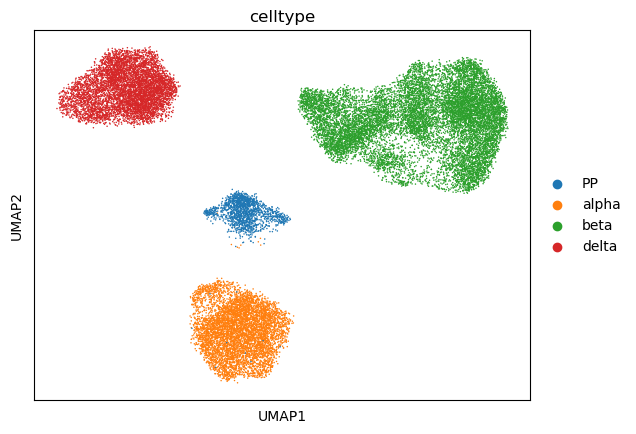

In [8]:
sc.pp.filter_genes_dispersion(adata_celltype,n_top_genes=3000)
sc.pp.filter_genes(adata_celltype, min_counts=20)
sc.pp.normalize_per_cell(adata_celltype, counts_per_cell_after=1e4)
sc.pp.log1p(adata_celltype)
sc.pp.pca(adata_celltype)
sc.pp.neighbors(adata_celltype)
sc.tl.umap(adata_celltype)
sc.pl.umap(adata_celltype,color=['celltype'])


In [9]:
adata= adata_celltype.copy()
mapping = {'alpha': 0, 'beta': 1, 'PP': 2, 'delta': 3}

# Map the values in the 'cell_type' column using the mapping dictionary
adata.obs['cell_type_mapped'] = adata.obs['celltype'].map(mapping)



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
n = adata.n_obs
conf_anno_tmp=[]
conf_nn=[]
conf_rf=[]
conf_svm=[]
conf_knn=[]
n=10000
for j in range(20):
        np.random.seed(j)
        bdata= adata.copy()
        sc.pp.subsample(bdata, n_obs=n)
        bdata.obs['change_weight']= np.zeros(bdata.n_obs)
        mapping = random_sample_and_number(list(bdata.obs['celltype'].unique()))
        bdata.obs['cell_type_mapped']= bdata.obs['celltype'].map(mapping)
        percent = float(np.clip((np.random.normal(0.5,0.1,1)),0.01,0.99))
        bdata = create_intermediate_state_percent(bdata,'cell_type_mapped',[0,1],percent)
        bdata = create_intermediate_state_percent(bdata,'cell_type_mapped',[2,3],percent)
        sc.pp.pca(bdata)
        prob_list = models.follow_training_dyn_neural_net(bdata,'cell_type_mapped', device=device, iterNum=20)
        all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= bdata.n_obs, epoch_num=20)
        bdata.obs['conf']=all_conf.detach().numpy()
        conf_anno_tmp.append(stats.spearmanr(bdata.obs['conf'], bdata.obs['change_weight'])[0])
        res = multi_ada_sampling_nn(bdata.X,bdata, 'cell_type_mapped', device=device)
        conf_nn.append((stats.spearmanr(res, bdata.obs['change_weight']))[0])
        res = multi_ada_sampling(bdata.obsm['X_pca'].T,bdata.obs['cell_type_mapped'], classifier="rf")
        conf = get_conf_from_scReClassify(bdata,res,bdata.obs['cell_type_mapped'])
        conf_rf.append((stats.spearmanr(conf, bdata.obs['change_weight']))[0])
        res = multi_ada_sampling(bdata.obsm['X_pca'].T,bdata.obs['cell_type_mapped'], classifier="svm")
        conf = get_conf_from_scReClassify(bdata,res,bdata.obs['cell_type_mapped'])
        conf_svm.append((stats.spearmanr(conf, bdata.obs['change_weight']))[0])
        res = multi_ada_sampling(bdata.obsm['X_pca'].T,bdata.obs['cell_type_mapped'], classifier="knn")
        conf = get_conf_from_scReClassify(bdata,res,bdata.obs['cell_type_mapped'])
        conf_knn.append((stats.spearmanr(conf, bdata.obs['change_weight']))[0])

        print(conf_nn)
        print(conf_anno_tmp)
        print(conf_knn)
        print(conf_rf)
        print(conf_svm)




/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.278
[1,    12] loss: 1.381
[1,    22] loss: 1.344
[1,    32] loss: 1.297
[2,     2] loss: 0.244
[2,    12] loss: 1.189
[2,    22] loss: 1.115
[2,    32] loss: 1.042
[3,     2] loss: 0.184
[3,    12] loss: 0.884
[3,    22] loss: 0.835
[3,    32] loss: 0.783
[4,     2] loss: 0.146
[4,    12] loss: 0.706
[4,    22] loss: 0.681
[4,    32] loss: 0.678
[5,     2] loss: 0.131
[5,    12] loss: 0.643
[5,    22] loss: 0.645
[5,    32] loss: 0.646
[6,     2] loss: 0.122
[6,    12] loss: 0.619
[6,    22] loss: 0.608
[6,    32] loss: 0.604
[7,     2] loss: 0.116
[7,    12] loss: 0.600
[7,    22] loss: 0.614
[7,    32] loss: 0.601
[8,     2] loss: 0.122
[8,    12] loss: 0.605
[8,    22] loss: 0.589
[8,    32] loss: 0.609
[9,     2] loss: 0.116
[9,    12] loss: 0.591
[9,    22] loss: 0.588
[9,    32] loss: 0.582
[10,     2] loss: 0.120
[10,    12] loss: 0.584
[10,    22] loss: 0.600
[10,    32] loss: 0.590
[11,     2] loss: 0.118
[11,    12] loss: 0.586
[11,    22] loss: 0.570
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697]
[-0.9065810957661927]
[-0.23995819620874137]
[-0.22449599549743948]
[-0.3881192541476769]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.277
[1,    12] loss: 1.372
[1,    22] loss: 1.317
[1,    32] loss: 1.246
[2,     2] loss: 0.225
[2,    12] loss: 1.059
[2,    22] loss: 0.954
[2,    32] loss: 0.849
[3,     2] loss: 0.152
[3,    12] loss: 0.730
[3,    22] loss: 0.683
[3,    32] loss: 0.667
[4,     2] loss: 0.128
[4,    12] loss: 0.650
[4,    22] loss: 0.632
[4,    32] loss: 0.629
[5,     2] loss: 0.119
[5,    12] loss: 0.621
[5,    22] loss: 0.603
[5,    32] loss: 0.625
[6,     2] loss: 0.125
[6,    12] loss: 0.601
[6,    22] loss: 0.605
[6,    32] loss: 0.602
[7,     2] loss: 0.117
[7,    12] loss: 0.602
[7,    22] loss: 0.582
[7,    32] loss: 0.576
[8,     2] loss: 0.121
[8,    12] loss: 0.593
[8,    22] loss: 0.583
[8,    32] loss: 0.574
[9,     2] loss: 0.119
[9,    12] loss: 0.581
[9,    22] loss: 0.599
[9,    32] loss: 0.587
[10,     2] loss: 0.114
[10,    12] loss: 0.586
[10,    22] loss: 0.591
[10,    32] loss: 0.570
[11,     2] loss: 0.116
[11,    12] loss: 0.561
[11,    22] loss: 0.552
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566]
[-0.9065810957661927, -0.9082813870580619]
[-0.23995819620874137, -0.27563580576149205]
[-0.22449599549743948, -0.26011369437224935]
[-0.3881192541476769, -0.5169578161287122]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.276
[1,    12] loss: 1.367
[1,    22] loss: 1.316
[1,    32] loss: 1.245
[2,     2] loss: 0.227
[2,    12] loss: 1.071
[2,    22] loss: 0.960
[2,    32] loss: 0.864
[3,     2] loss: 0.156
[3,    12] loss: 0.738
[3,    22] loss: 0.696
[3,    32] loss: 0.668
[4,     2] loss: 0.128
[4,    12] loss: 0.642
[4,    22] loss: 0.641
[4,    32] loss: 0.629
[5,     2] loss: 0.126
[5,    12] loss: 0.609
[5,    22] loss: 0.615
[5,    32] loss: 0.610
[6,     2] loss: 0.124
[6,    12] loss: 0.604
[6,    22] loss: 0.597
[6,    32] loss: 0.606
[7,     2] loss: 0.127
[7,    12] loss: 0.603
[7,    22] loss: 0.585
[7,    32] loss: 0.607
[8,     2] loss: 0.120
[8,    12] loss: 0.597
[8,    22] loss: 0.581
[8,    32] loss: 0.588
[9,     2] loss: 0.111
[9,    12] loss: 0.590
[9,    22] loss: 0.589
[9,    32] loss: 0.591
[10,     2] loss: 0.121
[10,    12] loss: 0.586
[10,    22] loss: 0.573
[10,    32] loss: 0.587
[11,     2] loss: 0.118
[11,    12] loss: 0.583
[11,    22] loss: 0.586
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.277
[1,    12] loss: 1.372
[1,    22] loss: 1.333
[1,    32] loss: 1.281
[2,     2] loss: 0.238
[2,    12] loss: 1.149
[2,    22] loss: 1.071
[2,    32] loss: 0.986
[3,     2] loss: 0.176
[3,    12] loss: 0.829
[3,    22] loss: 0.760
[3,    32] loss: 0.733
[4,     2] loss: 0.133
[4,    12] loss: 0.676
[4,    22] loss: 0.659
[4,    32] loss: 0.643
[5,     2] loss: 0.124
[5,    12] loss: 0.636
[5,    22] loss: 0.620
[5,    32] loss: 0.614
[6,     2] loss: 0.129
[6,    12] loss: 0.599
[6,    22] loss: 0.611
[6,    32] loss: 0.601
[7,     2] loss: 0.125
[7,    12] loss: 0.602
[7,    22] loss: 0.591
[7,    32] loss: 0.585
[8,     2] loss: 0.115
[8,    12] loss: 0.591
[8,    22] loss: 0.597
[8,    32] loss: 0.585
[9,     2] loss: 0.116
[9,    12] loss: 0.604
[9,    22] loss: 0.575
[9,    32] loss: 0.586
[10,     2] loss: 0.126
[10,    12] loss: 0.589
[10,    22] loss: 0.579
[10,    32] loss: 0.579
[11,     2] loss: 0.116
[11,    12] loss: 0.577
[11,    22] loss: 0.588
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.279
[1,    12] loss: 1.373
[1,    22] loss: 1.313
[1,    32] loss: 1.238
[2,     2] loss: 0.223
[2,    12] loss: 1.048
[2,    22] loss: 0.944
[2,    32] loss: 0.849
[3,     2] loss: 0.151
[3,    12] loss: 0.723
[3,    22] loss: 0.697
[3,    32] loss: 0.672
[4,     2] loss: 0.134
[4,    12] loss: 0.651
[4,    22] loss: 0.633
[4,    32] loss: 0.627
[5,     2] loss: 0.122
[5,    12] loss: 0.618
[5,    22] loss: 0.621
[5,    32] loss: 0.616
[6,     2] loss: 0.118
[6,    12] loss: 0.623
[6,    22] loss: 0.606
[6,    32] loss: 0.616
[7,     2] loss: 0.116
[7,    12] loss: 0.598
[7,    22] loss: 0.587
[7,    32] loss: 0.589
[8,     2] loss: 0.118
[8,    12] loss: 0.602
[8,    22] loss: 0.597
[8,    32] loss: 0.611
[9,     2] loss: 0.116
[9,    12] loss: 0.593
[9,    22] loss: 0.580
[9,    32] loss: 0.580
[10,     2] loss: 0.112
[10,    12] loss: 0.585
[10,    22] loss: 0.592
[10,    32] loss: 0.581
[11,     2] loss: 0.120
[11,    12] loss: 0.584
[11,    22] loss: 0.567
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524, -0.5431314778308923]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.276
[1,    12] loss: 1.373
[1,    22] loss: 1.339
[1,    32] loss: 1.295
[2,     2] loss: 0.241
[2,    12] loss: 1.172
[2,    22] loss: 1.100
[2,    32] loss: 1.023
[3,     2] loss: 0.185
[3,    12] loss: 0.882
[3,    22] loss: 0.823
[3,    32] loss: 0.778
[4,     2] loss: 0.144
[4,    12] loss: 0.700
[4,    22] loss: 0.683
[4,    32] loss: 0.666
[5,     2] loss: 0.129
[5,    12] loss: 0.637
[5,    22] loss: 0.623
[5,    32] loss: 0.635
[6,     2] loss: 0.122
[6,    12] loss: 0.618
[6,    22] loss: 0.612
[6,    32] loss: 0.610
[7,     2] loss: 0.129
[7,    12] loss: 0.627
[7,    22] loss: 0.616
[7,    32] loss: 0.598
[8,     2] loss: 0.119
[8,    12] loss: 0.584
[8,    22] loss: 0.602
[8,    32] loss: 0.612
[9,     2] loss: 0.111
[9,    12] loss: 0.593
[9,    22] loss: 0.595
[9,    32] loss: 0.595
[10,     2] loss: 0.121
[10,    12] loss: 0.598
[10,    22] loss: 0.586
[10,    32] loss: 0.582
[11,     2] loss: 0.116
[11,    12] loss: 0.588
[11,    22] loss: 0.584
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524, -0.5431314778308923, -0.38714236758737236]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.277
[1,    12] loss: 1.368
[1,    22] loss: 1.334
[1,    32] loss: 1.292
[2,     2] loss: 0.241
[2,    12] loss: 1.173
[2,    22] loss: 1.101
[2,    32] loss: 1.034
[3,     2] loss: 0.181
[3,    12] loss: 0.893
[3,    22] loss: 0.828
[3,    32] loss: 0.774
[4,     2] loss: 0.145
[4,    12] loss: 0.714
[4,    22] loss: 0.687
[4,    32] loss: 0.670
[5,     2] loss: 0.133
[5,    12] loss: 0.626
[5,    22] loss: 0.633
[5,    32] loss: 0.625
[6,     2] loss: 0.120
[6,    12] loss: 0.615
[6,    22] loss: 0.610
[6,    32] loss: 0.614
[7,     2] loss: 0.118
[7,    12] loss: 0.599
[7,    22] loss: 0.600
[7,    32] loss: 0.604
[8,     2] loss: 0.112
[8,    12] loss: 0.609
[8,    22] loss: 0.592
[8,    32] loss: 0.593
[9,     2] loss: 0.127
[9,    12] loss: 0.615
[9,    22] loss: 0.585
[9,    32] loss: 0.589
[10,     2] loss: 0.117
[10,    12] loss: 0.603
[10,    22] loss: 0.595
[10,    32] loss: 0.581
[11,     2] loss: 0.116
[11,    12] loss: 0.587
[11,    22] loss: 0.567
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524, -0.5431314778308923, -0.38714236758737236, -0.3870436042412781]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.278
[1,    12] loss: 1.367
[1,    22] loss: 1.331
[1,    32] loss: 1.286
[2,     2] loss: 0.241
[2,    12] loss: 1.169
[2,    22] loss: 1.097
[2,    32] loss: 1.021
[3,     2] loss: 0.186
[3,    12] loss: 0.873
[3,    22] loss: 0.827
[3,    32] loss: 0.775
[4,     2] loss: 0.147
[4,    12] loss: 0.722
[4,    22] loss: 0.680
[4,    32] loss: 0.673
[5,     2] loss: 0.126
[5,    12] loss: 0.642
[5,    22] loss: 0.637
[5,    32] loss: 0.631
[6,     2] loss: 0.124
[6,    12] loss: 0.619
[6,    22] loss: 0.625
[6,    32] loss: 0.603
[7,     2] loss: 0.122
[7,    12] loss: 0.595
[7,    22] loss: 0.601
[7,    32] loss: 0.611
[8,     2] loss: 0.122
[8,    12] loss: 0.584
[8,    22] loss: 0.588
[8,    32] loss: 0.583
[9,     2] loss: 0.117
[9,    12] loss: 0.591
[9,    22] loss: 0.581
[9,    32] loss: 0.570
[10,     2] loss: 0.117
[10,    12] loss: 0.595
[10,    22] loss: 0.584
[10,    32] loss: 0.586
[11,     2] loss: 0.115
[11,    12] loss: 0.588
[11,    22] loss: 0.576
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644, -0.22372168241146742]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524, -0.5431314778308923, -0.38714236758737236, -0.3870436042412781, -0.387220000690103]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.279
[1,    12] loss: 1.382
[1,    22] loss: 1.352
[1,    32] loss: 1.309
[2,     2] loss: 0.248
[2,    12] loss: 1.211
[2,    22] loss: 1.143
[2,    32] loss: 1.074
[3,     2] loss: 0.193
[3,    12] loss: 0.931
[3,    22] loss: 0.873
[3,    32] loss: 0.800
[4,     2] loss: 0.155
[4,    12] loss: 0.722
[4,    22] loss: 0.698
[4,    32] loss: 0.675
[5,     2] loss: 0.131
[5,    12] loss: 0.662
[5,    22] loss: 0.634
[5,    32] loss: 0.634
[6,     2] loss: 0.123
[6,    12] loss: 0.606
[6,    22] loss: 0.614
[6,    32] loss: 0.612
[7,     2] loss: 0.123
[7,    12] loss: 0.603
[7,    22] loss: 0.601
[7,    32] loss: 0.594
[8,     2] loss: 0.121
[8,    12] loss: 0.607
[8,    22] loss: 0.617
[8,    32] loss: 0.605
[9,     2] loss: 0.119
[9,    12] loss: 0.586
[9,    22] loss: 0.598
[9,    32] loss: 0.585
[10,     2] loss: 0.117
[10,    12] loss: 0.581
[10,    22] loss: 0.568
[10,    32] loss: 0.578
[11,     2] loss: 0.119
[11,    12] loss: 0.588
[11,    22] loss: 0.579
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644, -0.22372168241146742, -0.21656674265301926]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524, -0.5431314778308923, -0.38714236758737236, -0.3870436042412781, -0.387220000690103, -0.3870538088171394]


/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.278
[1,    12] loss: 1.371
[1,    22] loss: 1.320
[1,    32] loss: 1.250
[2,     2] loss: 0.225
[2,    12] loss: 1.069
[2,    22] loss: 0.960
[2,    32] loss: 0.865
[3,     2] loss: 0.151
[3,    12] loss: 0.731
[3,    22] loss: 0.704
[3,    32] loss: 0.670
[4,     2] loss: 0.127
[4,    12] loss: 0.647
[4,    22] loss: 0.623
[4,    32] loss: 0.623
[5,     2] loss: 0.123
[5,    12] loss: 0.618
[5,    22] loss: 0.608
[5,    32] loss: 0.619
[6,     2] loss: 0.124
[6,    12] loss: 0.607
[6,    22] loss: 0.600
[6,    32] loss: 0.607
[7,     2] loss: 0.117
[7,    12] loss: 0.609
[7,    22] loss: 0.596
[7,    32] loss: 0.596
[8,     2] loss: 0.122
[8,    12] loss: 0.611
[8,    22] loss: 0.591
[8,    32] loss: 0.584
[9,     2] loss: 0.117
[9,    12] loss: 0.583
[9,    22] loss: 0.591
[9,    32] loss: 0.579
[10,     2] loss: 0.112
[10,    12] loss: 0.588
[10,    22] loss: 0.582
[10,    32] loss: 0.580
[11,     2] loss: 0.115
[11,    12] loss: 0.581
[11,    22] loss: 0.576
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644, -0.22372168241146742, -0.21656674265301926, -0.2884512756894736]
[-0.3881192541476769, -0.5169578161287122, -0.5167905308827184, -0.5339055452413524, -0.5431314778308923, -0.38714236758737236, -0.38704360424

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.279
[1,    12] loss: 1.381
[1,    22] loss: 1.328
[1,    32] loss: 1.259
[2,     2] loss: 0.228
[2,    12] loss: 1.084
[2,    22] loss: 0.973
[2,    32] loss: 0.878
[3,     2] loss: 0.157
[3,    12] loss: 0.735
[3,    22] loss: 0.702
[3,    32] loss: 0.674
[4,     2] loss: 0.130
[4,    12] loss: 0.646
[4,    22] loss: 0.639
[4,    32] loss: 0.638
[5,     2] loss: 0.125
[5,    12] loss: 0.617
[5,    22] loss: 0.621
[5,    32] loss: 0.610
[6,     2] loss: 0.123
[6,    12] loss: 0.610
[6,    22] loss: 0.600
[6,    32] loss: 0.607
[7,     2] loss: 0.124
[7,    12] loss: 0.596
[7,    22] loss: 0.593
[7,    32] loss: 0.591
[8,     2] loss: 0.123
[8,    12] loss: 0.585
[8,    22] loss: 0.583
[8,    32] loss: 0.599
[9,     2] loss: 0.118
[9,    12] loss: 0.585
[9,    22] loss: 0.582
[9,    32] loss: 0.591
[10,     2] loss: 0.115
[10,    12] loss: 0.582
[10,    22] loss: 0.584
[10,    32] loss: 0.590
[11,     2] loss: 0.114
[11,    12] loss: 0.604
[11,    22] loss: 0.589
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644, -0.22372168241146742, -0.21656674265301926, -0.2884512756894736, -0.2630664823944052]
[-0.3881192541476769, -0.5169578161287122, -0.51679053088

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.281
[1,    12] loss: 1.384
[1,    22] loss: 1.350
[1,    32] loss: 1.313
[2,     2] loss: 0.248
[2,    12] loss: 1.206
[2,    22] loss: 1.145
[2,    32] loss: 1.070
[3,     2] loss: 0.192
[3,    12] loss: 0.935
[3,    22] loss: 0.860
[3,    32] loss: 0.817
[4,     2] loss: 0.151
[4,    12] loss: 0.733
[4,    22] loss: 0.700
[4,    32] loss: 0.670
[5,     2] loss: 0.134
[5,    12] loss: 0.661
[5,    22] loss: 0.647
[5,    32] loss: 0.638
[6,     2] loss: 0.127
[6,    12] loss: 0.635
[6,    22] loss: 0.628
[6,    32] loss: 0.595
[7,     2] loss: 0.124
[7,    12] loss: 0.616
[7,    22] loss: 0.628
[7,    32] loss: 0.604
[8,     2] loss: 0.114
[8,    12] loss: 0.598
[8,    22] loss: 0.589
[8,    32] loss: 0.587
[9,     2] loss: 0.123
[9,    12] loss: 0.597
[9,    22] loss: 0.592
[9,    32] loss: 0.590
[10,     2] loss: 0.112
[10,    12] loss: 0.572
[10,    22] loss: 0.597
[10,    32] loss: 0.590
[11,     2] loss: 0.114
[11,    12] loss: 0.573
[11,    22] loss: 0.563
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, -0.23950114348084425]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644, -0.22372168241146742, -0.21656674265301926, -0.2884512756894736, -0.2630664823

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.280
[1,    12] loss: 1.381
[1,    22] loss: 1.343
[1,    32] loss: 1.299
[2,     2] loss: 0.244
[2,    12] loss: 1.186
[2,    22] loss: 1.112
[2,    32] loss: 1.036
[3,     2] loss: 0.189
[3,    12] loss: 0.900
[3,    22] loss: 0.836
[3,    32] loss: 0.779
[4,     2] loss: 0.143
[4,    12] loss: 0.715
[4,    22] loss: 0.692
[4,    32] loss: 0.660
[5,     2] loss: 0.130
[5,    12] loss: 0.646
[5,    22] loss: 0.643
[5,    32] loss: 0.630
[6,     2] loss: 0.126
[6,    12] loss: 0.630
[6,    22] loss: 0.620
[6,    32] loss: 0.599
[7,     2] loss: 0.118
[7,    12] loss: 0.620
[7,    22] loss: 0.606
[7,    32] loss: 0.592
[8,     2] loss: 0.121
[8,    12] loss: 0.588
[8,    22] loss: 0.591
[8,    32] loss: 0.582
[9,     2] loss: 0.126
[9,    12] loss: 0.595
[9,    22] loss: 0.584
[9,    32] loss: 0.579
[10,     2] loss: 0.121
[10,    12] loss: 0.583
[10,    22] loss: 0.580
[10,    32] loss: 0.585
[11,     2] loss: 0.120
[11,    12] loss: 0.593
[11,    22] loss: 0.582
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, -0.23950114348084425, -0.25548497600158926]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.2954065599011894, -0.22117968124294135, -0.21624630232472644, -0.22372168241

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.279
[1,    12] loss: 1.372
[1,    22] loss: 1.325
[1,    32] loss: 1.259
[2,     2] loss: 0.230
[2,    12] loss: 1.084
[2,    22] loss: 0.978
[2,    32] loss: 0.874
[3,     2] loss: 0.153
[3,    12] loss: 0.746
[3,    22] loss: 0.704
[3,    32] loss: 0.673
[4,     2] loss: 0.132
[4,    12] loss: 0.650
[4,    22] loss: 0.638
[4,    32] loss: 0.633
[5,     2] loss: 0.125
[5,    12] loss: 0.633
[5,    22] loss: 0.625
[5,    32] loss: 0.614
[6,     2] loss: 0.129
[6,    12] loss: 0.606
[6,    22] loss: 0.612
[6,    32] loss: 0.596
[7,     2] loss: 0.121
[7,    12] loss: 0.604
[7,    22] loss: 0.595
[7,    32] loss: 0.603
[8,     2] loss: 0.121
[8,    12] loss: 0.606
[8,    22] loss: 0.591
[8,    32] loss: 0.581
[9,     2] loss: 0.117
[9,    12] loss: 0.588
[9,    22] loss: 0.575
[9,    32] loss: 0.593
[10,     2] loss: 0.120
[10,    12] loss: 0.588
[10,    22] loss: 0.573
[10,    32] loss: 0.586
[11,     2] loss: 0.115
[11,    12] loss: 0.580
[11,    22] loss: 0.585
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, -0.23950114348084425, -0.25548497600158926, -0.25720833365984963]
[-0.22449599549743948, -0.26011369437224935, -0.25872168263648265, -0.26428532011051276, -0.29540655990

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.277
[1,    12] loss: 1.386
[1,    22] loss: 1.347
[1,    32] loss: 1.306
[2,     2] loss: 0.246
[2,    12] loss: 1.200
[2,    22] loss: 1.138
[2,    32] loss: 1.058
[3,     2] loss: 0.192
[3,    12] loss: 0.907
[3,    22] loss: 0.859
[3,    32] loss: 0.797
[4,     2] loss: 0.142
[4,    12] loss: 0.716
[4,    22] loss: 0.689
[4,    32] loss: 0.687
[5,     2] loss: 0.125
[5,    12] loss: 0.637
[5,    22] loss: 0.638
[5,    32] loss: 0.635
[6,     2] loss: 0.125
[6,    12] loss: 0.619
[6,    22] loss: 0.622
[6,    32] loss: 0.615
[7,     2] loss: 0.124
[7,    12] loss: 0.606
[7,    22] loss: 0.599
[7,    32] loss: 0.607
[8,     2] loss: 0.118
[8,    12] loss: 0.612
[8,    22] loss: 0.594
[8,    32] loss: 0.586
[9,     2] loss: 0.121
[9,    12] loss: 0.579
[9,    22] loss: 0.594
[9,    32] loss: 0.589
[10,     2] loss: 0.115
[10,    12] loss: 0.591
[10,    22] loss: 0.580
[10,    32] loss: 0.576
[11,     2] loss: 0.115
[11,    12] loss: 0.601
[11,    22] loss: 0.584
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686, -0.44897173562603326]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673, -0.9118506362004358]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, -0.23950114348084425, -0.25548497600158926, -0.25720833365984963, -0.2605812123196976]
[-0.22449599549743948, -0.2601136943722

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.278
[1,    12] loss: 1.375
[1,    22] loss: 1.332
[1,    32] loss: 1.273
[2,     2] loss: 0.237
[2,    12] loss: 1.126
[2,    22] loss: 1.042
[2,    32] loss: 0.952
[3,     2] loss: 0.166
[3,    12] loss: 0.815
[3,    22] loss: 0.746
[3,    32] loss: 0.714
[4,     2] loss: 0.138
[4,    12] loss: 0.668
[4,    22] loss: 0.660
[4,    32] loss: 0.639
[5,     2] loss: 0.127
[5,    12] loss: 0.627
[5,    22] loss: 0.627
[5,    32] loss: 0.623
[6,     2] loss: 0.127
[6,    12] loss: 0.613
[6,    22] loss: 0.608
[6,    32] loss: 0.605
[7,     2] loss: 0.123
[7,    12] loss: 0.589
[7,    22] loss: 0.614
[7,    32] loss: 0.612
[8,     2] loss: 0.121
[8,    12] loss: 0.613
[8,    22] loss: 0.597
[8,    32] loss: 0.596
[9,     2] loss: 0.117
[9,    12] loss: 0.589
[9,    22] loss: 0.581
[9,    32] loss: 0.588
[10,     2] loss: 0.116
[10,    12] loss: 0.588
[10,    22] loss: 0.583
[10,    32] loss: 0.572
[11,     2] loss: 0.112
[11,    12] loss: 0.596
[11,    22] loss: 0.584
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686, -0.44897173562603326, -0.4650662611087763]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673, -0.9118506362004358, -0.9119971663151835]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, -0.23950114348084425, -0.25548497600158926, -0.25720833365984963, -0.260581212319697

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.278
[1,    12] loss: 1.373
[1,    22] loss: 1.331
[1,    32] loss: 1.274
[2,     2] loss: 0.240
[2,    12] loss: 1.147
[2,    22] loss: 1.064
[2,    32] loss: 0.973
[3,     2] loss: 0.168
[3,    12] loss: 0.818
[3,    22] loss: 0.772
[3,    32] loss: 0.733
[4,     2] loss: 0.140
[4,    12] loss: 0.675
[4,    22] loss: 0.667
[4,    32] loss: 0.633
[5,     2] loss: 0.122
[5,    12] loss: 0.621
[5,    22] loss: 0.632
[5,    32] loss: 0.633
[6,     2] loss: 0.118
[6,    12] loss: 0.615
[6,    22] loss: 0.603
[6,    32] loss: 0.609
[7,     2] loss: 0.122
[7,    12] loss: 0.612
[7,    22] loss: 0.602
[7,    32] loss: 0.601
[8,     2] loss: 0.123
[8,    12] loss: 0.602
[8,    22] loss: 0.604
[8,    32] loss: 0.601
[9,     2] loss: 0.119
[9,    12] loss: 0.590
[9,    22] loss: 0.575
[9,    32] loss: 0.578
[10,     2] loss: 0.115
[10,    12] loss: 0.592
[10,    22] loss: 0.595
[10,    32] loss: 0.570
[11,     2] loss: 0.114
[11,    12] loss: 0.587
[11,    22] loss: 0.580
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686, -0.44897173562603326, -0.4650662611087763, -0.4631127332006004]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673, -0.9118506362004358, -0.9119971663151835, -0.9120097308394705]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, -0.23950114348084425, -0.25548497600158926

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.277
[1,    12] loss: 1.372
[1,    22] loss: 1.333
[1,    32] loss: 1.288
[2,     2] loss: 0.238
[2,    12] loss: 1.162
[2,    22] loss: 1.090
[2,    32] loss: 1.023
[3,     2] loss: 0.184
[3,    12] loss: 0.888
[3,    22] loss: 0.822
[3,    32] loss: 0.775
[4,     2] loss: 0.146
[4,    12] loss: 0.705
[4,    22] loss: 0.687
[4,    32] loss: 0.670
[5,     2] loss: 0.124
[5,    12] loss: 0.644
[5,    22] loss: 0.635
[5,    32] loss: 0.616
[6,     2] loss: 0.119
[6,    12] loss: 0.631
[6,    22] loss: 0.611
[6,    32] loss: 0.609
[7,     2] loss: 0.121
[7,    12] loss: 0.614
[7,    22] loss: 0.614
[7,    32] loss: 0.596
[8,     2] loss: 0.121
[8,    12] loss: 0.599
[8,    22] loss: 0.590
[8,    32] loss: 0.596
[9,     2] loss: 0.118
[9,    12] loss: 0.600
[9,    22] loss: 0.582
[9,    32] loss: 0.585
[10,     2] loss: 0.120
[10,    12] loss: 0.585
[10,    22] loss: 0.577
[10,    32] loss: 0.583
[11,     2] loss: 0.122
[11,    12] loss: 0.575
[11,    22] loss: 0.578
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686, -0.44897173562603326, -0.4650662611087763, -0.4631127332006004, -0.4540755353357609]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673, -0.9118506362004358, -0.9119971663151835, -0.9120097308394705, -0.9125406995198692]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -0.2651942782050023, -0.27029522491574565, 

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.277
[1,    12] loss: 1.372
[1,    22] loss: 1.334
[1,    32] loss: 1.284
[2,     2] loss: 0.238
[2,    12] loss: 1.155
[2,    22] loss: 1.062
[2,    32] loss: 0.980
[3,     2] loss: 0.169
[3,    12] loss: 0.828
[3,    22] loss: 0.767
[3,    32] loss: 0.735
[4,     2] loss: 0.140
[4,    12] loss: 0.674
[4,    22] loss: 0.653
[4,    32] loss: 0.643
[5,     2] loss: 0.126
[5,    12] loss: 0.631
[5,    22] loss: 0.618
[5,    32] loss: 0.626
[6,     2] loss: 0.121
[6,    12] loss: 0.605
[6,    22] loss: 0.617
[6,    32] loss: 0.611
[7,     2] loss: 0.116
[7,    12] loss: 0.603
[7,    22] loss: 0.611
[7,    32] loss: 0.593
[8,     2] loss: 0.121
[8,    12] loss: 0.591
[8,    22] loss: 0.582
[8,    32] loss: 0.604
[9,     2] loss: 0.122
[9,    12] loss: 0.603
[9,    22] loss: 0.596
[9,    32] loss: 0.566
[10,     2] loss: 0.109
[10,    12] loss: 0.586
[10,    22] loss: 0.567
[10,    32] loss: 0.588
[11,     2] loss: 0.124
[11,    12] loss: 0.569
[11,    22] loss: 0.575
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686, -0.44897173562603326, -0.4650662611087763, -0.4631127332006004, -0.4540755353357609, -0.4647115867410112]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673, -0.9118506362004358, -0.9119971663151835, -0.9120097308394705, -0.9125406995198692, -0.9126204522757687]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -0.2589696470098039, -0.24050034129498407, -

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/Annotatability/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.279
[1,    12] loss: 1.385
[1,    22] loss: 1.345
[1,    32] loss: 1.293
[2,     2] loss: 0.244
[2,    12] loss: 1.168
[2,    22] loss: 1.087
[2,    32] loss: 1.000
[3,     2] loss: 0.175
[3,    12] loss: 0.846
[3,    22] loss: 0.779
[3,    32] loss: 0.736
[4,     2] loss: 0.136
[4,    12] loss: 0.695
[4,    22] loss: 0.659
[4,    32] loss: 0.645
[5,     2] loss: 0.128
[5,    12] loss: 0.647
[5,    22] loss: 0.646
[5,    32] loss: 0.613
[6,     2] loss: 0.124
[6,    12] loss: 0.608
[6,    22] loss: 0.615
[6,    32] loss: 0.593
[7,     2] loss: 0.122
[7,    12] loss: 0.596
[7,    22] loss: 0.596
[7,    32] loss: 0.600
[8,     2] loss: 0.121
[8,    12] loss: 0.608
[8,    22] loss: 0.605
[8,    32] loss: 0.591
[9,     2] loss: 0.118
[9,    12] loss: 0.594
[9,    22] loss: 0.579
[9,    32] loss: 0.590
[10,     2] loss: 0.122
[10,    12] loss: 0.579
[10,    22] loss: 0.585
[10,    32] loss: 0.588
[11,     2] loss: 0.113
[11,    12] loss: 0.585
[11,    22] loss: 0.567
[11,

/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/cs/labs/mornitzan/karinjo/miniconda/envs/rev17/lib/python3.7/site-packages/ipykernel_launch

[-0.4319287549245697, -0.4225461287633566, -0.4339608999501223, -0.4685102895457026, -0.4739183877549813, -0.4435927326837245, -0.43157757374707517, -0.4424419214678022, -0.4353487852581571, -0.4901592026916051, -0.4626833662344737, -0.44577643988544424, -0.4359197372477691, -0.47363579123842686, -0.44897173562603326, -0.4650662611087763, -0.4631127332006004, -0.4540755353357609, -0.4647115867410112, -0.46779512956104613]
[-0.9065810957661927, -0.9082813870580619, -0.9088258539775151, -0.9130841531485323, -0.909173193427424, -0.9082944275928043, -0.905485575668907, -0.9102573576739144, -0.9082397400445816, -0.9074034497258182, -0.9092622615428969, -0.9085150355416023, -0.9084115169602686, -0.9074560724772673, -0.9118506362004358, -0.9119971663151835, -0.9120097308394705, -0.9125406995198692, -0.9126204522757687, -0.9119826475287084]
[-0.23995819620874137, -0.27563580576149205, -0.27243164051823526, -0.26490127962475934, -0.2657122633286158, -0.23950114348084425, -0.25300211220288177, -

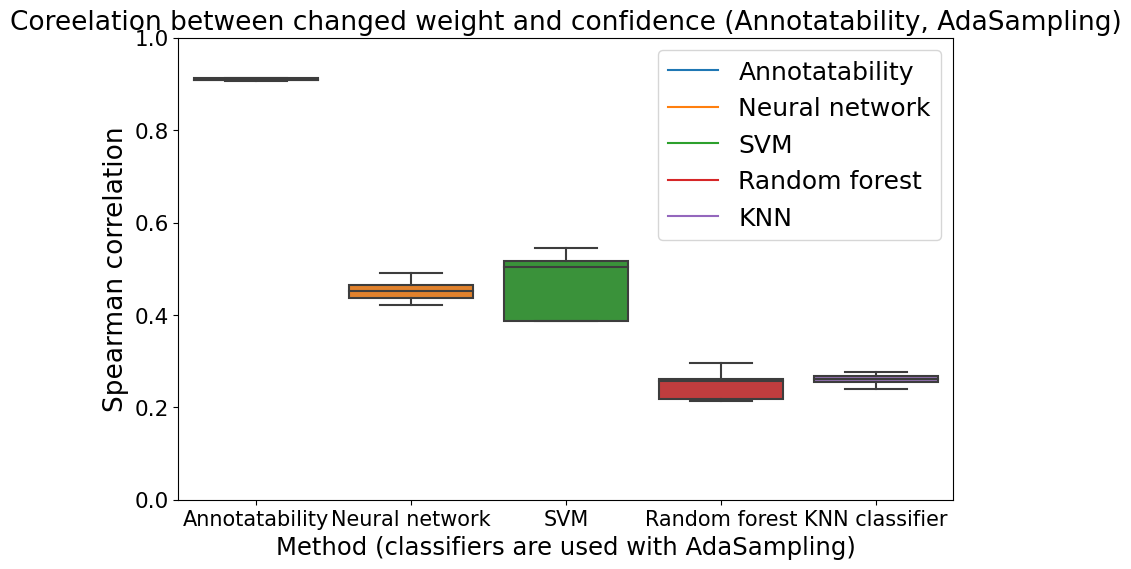

In [17]:
data = pd.DataFrame({
    'Annotatability': np.abs(conf_anno_tmp),
    'Neural network': np.abs(conf_nn),
    'SVM': np.abs(conf_svm),
    'Random forest': np.abs(conf_rf),
    'KNN classifier': np.abs(conf_knn)
})

# Melt the DataFrame to a long format
melted_data = pd.melt(data)

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='variable', y='value', data=melted_data)

# Add labels
plt.xlabel('Method (classifiers are used with AdaSampling)', fontsize=17.5)
plt.ylabel('Spearman correlation', fontsize=19)
plt.title('Coreelation between changed weight and confidence (Annotatability, AdaSampling)', fontsize=19)
plt.ylim([0,1])
legend_labels = ['Annotatability', 'Neural network', 'SVM', 'Random forest', 'KNN']
for i, label in enumerate(legend_labels):
    boxplot.plot([], [], label=label)

plt.legend( fontsize=18)
plt.xticks( fontsize=15)
plt.yticks( fontsize=15.5)
# Show the plot
plt.show()


In [12]:
print(np.mean(np.abs(conf_anno_tmp)))
print(np.mean(np.abs(conf_nn)))
print(np.mean(np.abs(conf_svm)))
print(np.mean(np.abs(conf_rf)))
print(np.mean(np.abs(conf_knn)))

0.9096136226642612
0.45278664964832194
0.46083863302612366
0.2465012818590401
0.25916060722421663


In [13]:
print(np.median(np.abs(conf_anno_tmp)))
print(np.median(np.abs(conf_nn)))
print(np.median(np.abs(conf_svm)))
print(np.median(np.abs(conf_rf)))
print(np.median(np.abs(conf_knn)))

0.9089995237024695
0.4515236354808971
0.5046829341367733
0.25597893573695857
0.260933955047257


In [14]:
print(np.var(np.abs(conf_anno_tmp)))
print(np.var(np.abs(conf_nn)))
print(np.var(np.abs(conf_svm)))
print(np.var(np.abs(conf_rf)))
print(np.var(np.abs(conf_knn)))

4.843821309134432e-06
0.0003123621954127206
0.004611674000848666
0.000744233604425437
0.0001241884350370296
